# GMNS/Network Wrangler 2.0 Workshop

***Placeholder text from workshop overview:*** *Building and maintaining transportation networks for travel models is often time-consuming and error-prone. This workshop introduces the General Modeling Network Specification (GMNS), a standardized, human- and machine-readable format developed by the Zephyr Foundation with support from FHWA. GMNS enables easier sharing of routable road network files across platforms and agencies.  Participants will also explore Network Wrangler 2.0, an open-source Python tool that simplifies network editing through “Project Cards” - standardized, human- and machine-readable text files that describe proposed changes to roadway, transit, pedestrian, or bicycle infrastructure. The tool automates network updates, supports scenario management, and facilitates collaboration across agencies and software platforms.  This hands-on workshop will guide participants through building GMNS- and Network Wrangler-ready travel model networks from scratch using open-source data. Attendees will learn how to create network scenarios with Network Wrangler and perform network analysis with GMNS standard networks, including transit accessibility evaluation. Live demonstrations will showcase how these tools streamline network development and scenario management for regional transportation planning.*  


## Workflow Overview:

*Insert updata workflow*

In [1]:
import argparse
import datetime
import pathlib
import pickle
import pprint
import requests
import statistics
import sys
from typing import Any, Optional, Tuple, Union

import networkx
import osmnx
import numpy as np
import pandas as pd
import geopandas as gpd
import pygris
import shapely.geometry

import folium
from folium import plugins
import seaborn as sns

import tableau_utils
import network_wrangler
from network_wrangler import WranglerLogger
from network_wrangler.params import LAT_LON_CRS
from network_wrangler.roadway.network import RoadwayNetwork
from network_wrangler.roadway.io import load_roadway_from_dataframes, write_roadway
from network_wrangler.roadway.clip import clip_roadway, clip_roadway_to_dfs
from network_wrangler.models.gtfs.gtfs import GtfsModel
from network_wrangler.transit.feed.feed import Feed
from network_wrangler.transit.network import TransitNetwork
from network_wrangler.transit.io import load_feed_from_path, write_transit, load_transit
from network_wrangler.models.gtfs.types import RouteType
from network_wrangler.utils.transit import \
  drop_transit_agency, filter_transit_by_boundary, create_feed_from_gtfs_model
from network_wrangler.roadway.centroids import FitForCentroidConnection, add_centroid_nodes, add_centroid_connectors

from visualization import *

import sys
sys.path.append('../create_baseyear_network')
from create_mtc_network_from_OSM import(
    get_travel_model_zones,
    stepa_standardize_attributes,
    step1_download_osm_network,
    step2_simplify_network_topology,
    step3_assign_county_node_link_numbering,
    step4_add_centroids_and_connectors,
    step5_prepare_gtfs_transit_data,
    step6_create_transit_network,
)

In [2]:
OUTPUT_DIR = pathlib.Path("output_OSM").resolve()
OUTPUT_DIR.mkdir(exist_ok=True)
INPUT_2023GTFS = pathlib.Path("M:/Data/Transit/511/2023-09")

from network_wrangler import WranglerLogger
import pathlib
info_log_file = OUTPUT_DIR / "create_SF_network_info.log"
debug_log_file = OUTPUT_DIR / "create_SF_network_debug.log"
network_wrangler.setup_logging(
    info_log_file,
    debug_log_file,
    std_out_level="info",
    file_mode="w"
  )

# We have custom loggers and we want to prevent their messages from being
# processed by the root logger's handlers (if any remain)
WranglerLogger.propagate = False

# this one will just go to the debug file
WranglerLogger.debug("Debug test")
# this will go to the console (stdout) and the info & debug files
WranglerLogger.info("Info test")

2025-09-12 13:35:48, INFO: Info test


In [3]:
# fetch travel model zones; this will save into OUTPUT_DIR/mtc_zones
travel_model_zones = get_travel_model_zones(OUTPUT_DIR)
print(travel_model_zones["TAZ"])

2025-09-12 13:35:48, INFO: Looking for MTC zones files in /Users/lmz/Library/Mobile Documents/com~apple~CloudDocs/MTC/mtc_wrangler/momo_workshop/output_OSM/mtc_zones
2025-09-12 13:35:48, INFO: Read MAZ shapefile from /Users/lmz/Library/Mobile Documents/com~apple~CloudDocs/MTC/mtc_wrangler/momo_workshop/output_OSM/mtc_zones/mazs_TM2_2_5.shp
2025-09-12 13:35:49, INFO: Read TAZ shapefile from /Users/lmz/Library/Mobile Documents/com~apple~CloudDocs/MTC/mtc_wrangler/momo_workshop/output_OSM/mtc_zones/tazs_TM2_2_5.shp
         TAZ         county  \
0          1  San Francisco   
1          2  San Francisco   
2          3  San Francisco   
3          4  San Francisco   
4          5  San Francisco   
...      ...            ...   
4729  800206          Marin   
4730  800207          Marin   
4731  800208          Marin   
4732  800209          Marin   
4733  800210          Marin   

                                               geometry  \
0     POLYGON ((-122.42457 37.76913, -122.42466 37

## Step 1: Download OSM network data
Gets raw road network from OpenStreetMap

In [4]:
# Download the OSM network data for San Francisco county
osm_g = step1_download_osm_network(county="San Francisco", output_dir=OUTPUT_DIR) 

2025-09-12 13:35:49, INFO: ======= STEP 1: Download OSM network for San Francisco =======
2025-09-12 13:35:49, INFO: Loaded cached OSM graph from /Users/lmz/Library/Mobile Documents/com~apple~CloudDocs/MTC/mtc_wrangler/momo_workshop/output_OSM/1_graph_OSM_SanFrancisco.pkl
2025-09-12 13:35:49, INFO: Graph has 169,335 edges and 57,674 nodes


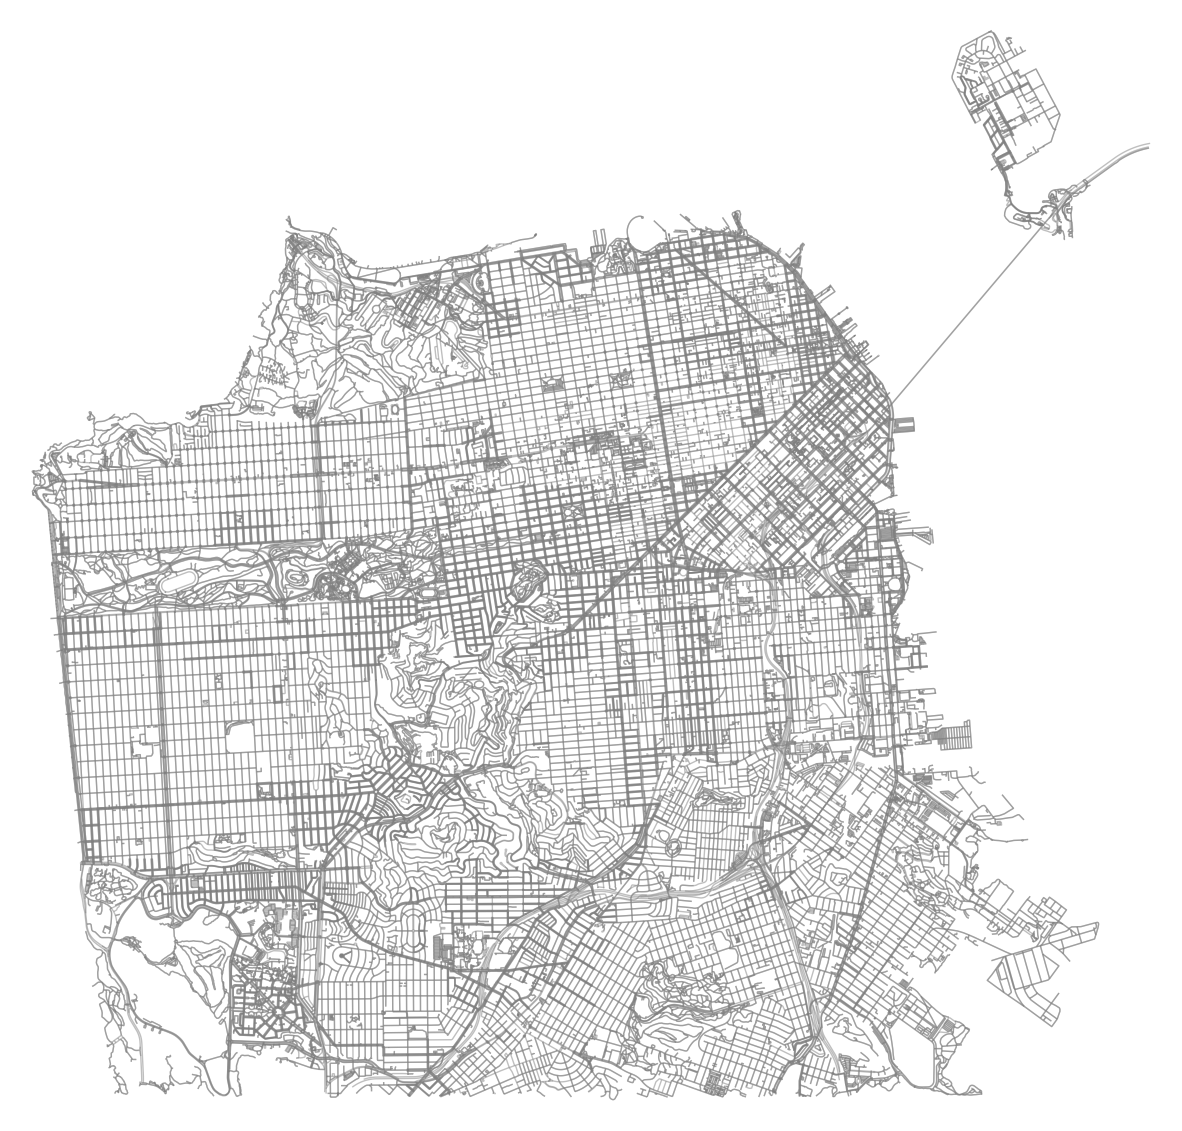

In [5]:
# Visualize the network
fig, ax = create_osmnx_plot(osm_g)

## Step 1A: Standardize attributes (and write)  
Note: we don't keep the results of this, since we'll use version from the simplified graph  
*VIZ: visualize complicated block - van ness with bus lanes and footway a couple blocks north of market*

In [6]:
links_unsimplified_gdf, nodes_unsimplified_gdf = stepa_standardize_attributes(
    osm_g, 
    county="San Francisco", 
    prefix="1a_original_", 
    output_dir=OUTPUT_DIR,
    output_formats=["geojson"]
)

2025-09-12 13:35:52, INFO: ======= STEP 1a: Standardize attributes for San Francisco =======
2025-09-12 13:35:56, INFO: After converting to gdfs, len(edges_gdf)=169,335 and len(nodes_gdf)=57,674
2025-09-12 13:35:56, INFO: links_gdf has 169,020 links after dropping loop links (with u==v)
2025-09-12 13:35:58, INFO: Filling 146,843 links with missing lane counts using highway type mapping
2025-09-12 13:35:58, INFO: Found 224 links with missing lanes, assuming 1 lane
2025-09-12 13:35:58, INFO: After standardize_lanes_value:
lanes
0    91610
1    65072
2    10212
3     1772
4      260
5       91
6        3
Name: count, dtype: int64
2025-09-12 13:35:58, INFO: buslanes:
buslanes
0    168522
1       498
Name: count, dtype: int64
2025-09-12 13:35:58, INFO: Handling links with duplicate (A,B)
2025-09-12 13:35:58, INFO: Removing 16,746 nameless service links
2025-09-12 13:36:01, INFO: Wrote /Users/lmz/Library/Mobile Documents/com~apple~CloudDocs/MTC/mtc_wrangler/momo_workshop/output_OSM/1a_origin

## Step 2: Simplify network topology  
Consolidates intersections while preserving connectivity

In [7]:
simplified_g = step2_simplify_network_topology(osm_g, county="San Francisco", output_dir=OUTPUT_DIR)

2025-09-12 13:36:01, INFO: ======= STEP 2: Simplify network topology for San Francisco =======
2025-09-12 13:36:02, INFO: Loaded cached simplified graph from /Users/lmz/Library/Mobile Documents/com~apple~CloudDocs/MTC/mtc_wrangler/momo_workshop/output_OSM/2_graph_OSM_SanFrancisco_simplified20.pkl
2025-09-12 13:36:02, INFO: Simplified graph has 91,669 edges and 25,662 nodes


=== Network Comparison: Original OSM vs Simplified OSM ===

📊 BASIC STATISTICS
Nodes: 57,674 → 25,662 (44.5% remaining)
Edges: 169,335 → 91,669 (54.1% remaining)
Nodes removed: 32,012 (55.5%)
Edges removed: 77,666 (45.9%)

🔗 CONNECTIVITY ANALYSIS
Average degree: 5.87 → 7.14
Max degree: 16 → 46

Degree 2 nodes (typical street continuation): 6,502 → 4,000
Degree 3 nodes (T-intersections): 1,543 → 839
Degree 4+ nodes (complex intersections): 49,547 → 20,795

📏 EDGE LENGTH ANALYSIS
Average edge length: 42.8m → 209.4m
Total network length: 7253.1km → 19199.2km
Shortest edge: 0.0m → 12.2m
Longest edge: 3697.1m → 12131.6m


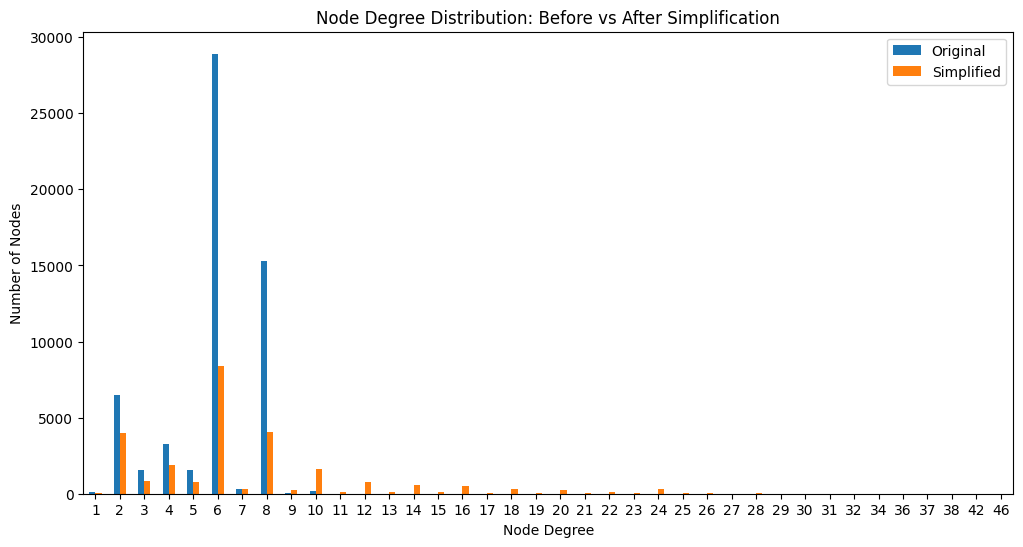

In [8]:
compare_original_and_simplified_networks(osm_g, simplified_g)
plot_node_degree_changes(osm_g, simplified_g)

## Step 2A Standardize attributes and write
*VIZ: same as 1a for contrast*

In [9]:
links_gdf, nodes_gdf = stepa_standardize_attributes(
    simplified_g, county="San Francisco", 
    prefix="2a_simplified", 
    output_dir=OUTPUT_DIR,
    output_formats=["geojson"]
)

2025-09-12 13:36:02, INFO: ======= STEP 2a: Standardize attributes for San Francisco =======
2025-09-12 13:36:04, INFO: After converting to gdfs, len(edges_gdf)=91,669 and len(nodes_gdf)=25,662
2025-09-12 13:36:04, INFO: links_gdf has 91,354 links after dropping loop links (with u==v)
2025-09-12 13:36:06, INFO: Filling 77,569 links with missing lane counts using highway type mapping
2025-09-12 13:36:06, INFO: Found 183 links with missing lanes, assuming 1 lane
2025-09-12 13:36:06, INFO: After standardize_lanes_value:
lanes
1    42990
0    39849
2     4681
3     3506
4      243
5       83
6        2
Name: count, dtype: int64
2025-09-12 13:36:06, INFO: buslanes:
buslanes
0    91133
1      221
Name: count, dtype: int64
2025-09-12 13:36:06, INFO: Handling links with duplicate (A,B)
2025-09-12 13:36:06, INFO: Removing 11,130 nameless service links
2025-09-12 13:36:07, INFO: Wrote /Users/lmz/Library/Mobile Documents/com~apple~CloudDocs/MTC/mtc_wrangler/momo_workshop/output_OSM/2a_simplifiedS

In [10]:
links_unsimplified_clip_gdf, links_clip_gdf = clip_original_and_simplified_links(links_unsimplified_gdf, links_gdf, travel_model_zones["TAZ"])
print(f"links_unsimplified_clip_gdf has length {len(links_unsimplified_clip_gdf)}")
print(f"links_clip_gdf has length {len(links_clip_gdf)}")

links_unsimplified_clip_gdf has length 2972
links_clip_gdf has length 1034


In [11]:
m = map_original_and_simplified_links(links_unsimplified_clip_gdf, links_clip_gdf, OUTPUT_DIR)
print(type(m))
m

Created map <class 'folium.plugins.dual_map.DualMap'>
<class 'folium.plugins.dual_map.DualMap'>


In [12]:
links_unsimplified_gdf["highway"].unique()

array(['footway', 'motorway', 'motorway_link', 'primary', 'residential',
       'busway', 'unclassified', 'tertiary', 'cycleway', 'service',
       'path', 'secondary', 'track', 'secondary_link', 'tertiary_link',
       'trunk', 'primary_link', 'trunk_link', 'living_street',
       'residential_link', 'corridor', 'bridleway', 'elevator'],
      dtype=object)

## Step 3: Assign county-specific numbering and create RoadwayNetwork object  
This also drops columns we're done with and writes the roadway network

In [13]:
roadway_network = step3_assign_county_node_link_numbering(links_gdf, nodes_gdf, county="San Francisco", output_dir=OUTPUT_DIR, output_formats=["geojson"])

2025-09-12 13:36:08, INFO: ======= STEP 3: Create roadway network with county numbering for San Francisco =======
2025-09-12 13:36:10, INFO: Saved roadway network in geojson format
2025-09-12 13:36:10, INFO: Created roadway network with 64637 links and 25662 nodes


## Step 4: Add centroids and centroid connectors  

In [14]:
step4_add_centroids_and_connectors(roadway_network, county="San Francisco", output_dir=OUTPUT_DIR, output_formats=["geojson"])

2025-09-12 13:36:10, INFO: ======= STEP 4: Create centroids and centroid connectors for San Francisco =======
2025-09-12 13:36:10, INFO: Looking for MTC zones files in /Users/lmz/Library/Mobile Documents/com~apple~CloudDocs/MTC/mtc_wrangler/momo_workshop/output_OSM/mtc_zones
2025-09-12 13:36:11, INFO: Read MAZ shapefile from /Users/lmz/Library/Mobile Documents/com~apple~CloudDocs/MTC/mtc_wrangler/momo_workshop/output_OSM/mtc_zones/mazs_TM2_2_5.shp
2025-09-12 13:36:11, INFO: Read TAZ shapefile from /Users/lmz/Library/Mobile Documents/com~apple~CloudDocs/MTC/mtc_wrangler/momo_workshop/output_OSM/mtc_zones/tazs_TM2_2_5.shp
2025-09-12 13:36:11, INFO: Filtered MAZ to San Francisco: 4,153 rows
2025-09-12 13:36:11, INFO: Filtered TAZ to San Francisco: 635 rows
2025-09-12 13:36:11, INFO: Added node centroids for TAZ: increased size of nodes_df from 25,662 to 26,297
2025-09-12 13:36:11, INFO: Adding centroid connectors for zone:TAZ and mode:drive
2025-09-12 13:36:14, INFO: Selected 2,536 centro

## STEP 5: Prepare GTFS transit data: Read and filter to service date, relevant operators. Creates GtfsModel object  
This also writes the GtfsModel as GTFS

In [ ]:
gtfs_model = step5_prepare_gtfs_transit_data(county="San Francisco", input_gtfs=INPUT_2023GTFS, output_dir=OUTPUT_DIR)

# STEP 6: Create TransitNetwork by integrating GtfsModel with RoadwayNetwork to create a Wrangler-flavored Feed object  
This writes the RoadwayNetwork and TransitNetwork

In [ ]:
transit_network = step6_create_transit_network(gtfs_model, roadway_network, county="San Francisco", output_dir=OUTPUT_DIR, output_formats=["parquet"])